In [100]:

import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px

train, X_test = pd.read_csv('train.csv'), pd.read_csv('test.csv')  
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1:]

y_train = y_train.astype(bool).astype(int)

In [101]:
def split_feature(feature: str, new_features: list, sep: str) -> None:
    X_train[new_features] = X_train[feature].str.split(sep, expand=True)
    X_test[new_features] = X_test[feature].str.split(sep, expand=True)


def drop_features(features: list) -> None:
    X_train.drop(features, axis=1, inplace=True)
    X_test.drop(features, axis=1, inplace=True)

    
def cast_feature(feature: str, cast: str) -> None:
    X_train[feature] = X_train[feature].astype(cast)
    X_test[feature] = X_test[feature].astype(cast)
    

split_feature('PassengerId', ['GroupId', 'IdWithinGroup'], '_')
split_feature('Cabin', ['Deck', 'Num', 'Side'], '/')

#drop_features(['Name', 'PassengerId', 'Cabin', 'IdWithinGroup', 'VIP', 'Num'])
drop_features(['Name', 'PassengerId', 'Cabin', 'IdWithinGroup', 'Num'])

for feature in ['GroupId']:
    cast_feature(feature, 'float')

<Axes: xlabel='VIP', ylabel='count'>

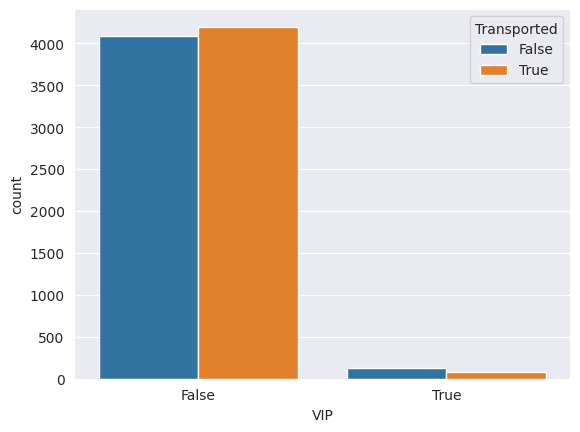

In [102]:
sns.countplot(data=train, x='VIP', hue='Transported')

In [103]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  GroupId       8693 non-null   float64
 11  Deck          8494 non-null   object 
 12  Side          8494 non-null   object 
dtypes: float64(7), object(6)
memory usage: 883.0+ KB


In [104]:
def count_na_values(df: pd.DataFrame) -> pd.DataFrame:
    # count missing values
    mis_val = df.isna().sum()

    # % misssing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    missing_values = pd.DataFrame()
    missing_values[['count missing values', '% of missing values']]= pd.concat([mis_val, mis_val_percent], axis=1)
    return missing_values


count_na_values(X_train)

,count missing values,% of missing values
HomePlanet,201,2.312205
CryoSleep,217,2.496261
Destination,182,2.093639
Age,179,2.059128
VIP,203,2.335212
RoomService,181,2.082135
FoodCourt,183,2.105142
ShoppingMall,208,2.392730
Spa,183,2.105142
VRDeck,188,2.162660


In [105]:
X_train[X_train['CryoSleep'] == True][
    ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
].value_counts()

RoomService  FoodCourt  ShoppingMall  Spa  VRDeck
0.0          0.0        0.0           0.0  0.0       2690
Name: count, dtype: int64

In [106]:
X_train[X_train['CryoSleep'] == True].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId
count,2955.000000,2969.0,2967.0,2941.0,2972.0,2975.0,3037.000000
mean,27.405415,0.0,0.0,0.0,0.0,0.0,4608.302601
std,15.080469,0.0,0.0,0.0,0.0,0.0,2686.395531
min,0.000000,0.0,0.0,0.0,0.0,0.0,6.000000
25%,18.000000,0.0,0.0,0.0,0.0,0.0,2329.000000
50%,26.000000,0.0,0.0,0.0,0.0,0.0,4580.000000
75%,37.000000,0.0,0.0,0.0,0.0,0.0,6858.000000
max,78.000000,0.0,0.0,0.0,0.0,0.0,9278.000000


In [107]:
def impute_cryo_sleep(df: pd.DataFrame) -> None:
    df.loc[
        ((df['RoomService'] == 0.0) | df['RoomService'].isnull()) & 
        ((df['FoodCourt'] == 0.0) | df['FoodCourt'].isnull()) & 
        ((df['ShoppingMall'] == 0.0) | df['ShoppingMall'].isnull()) & 
        ((df['Spa'] == 0.0) | df['Spa'].isnull()) &
        ((df['VRDeck'] == 0.0) | df['VRDeck'].isnull()) &
        (df['CryoSleep'].isnull()), 
        'CryoSleep'
    ] = True
    
    df.loc[
        ((df['RoomService'] > 0.0) | 
        (df['FoodCourt'] > 0.0) | 
        (df['ShoppingMall'] > 0.0) | 
        (df['Spa'] > 0.0) |
        (df['VRDeck'] > 0.0)) & (df['CryoSleep'].isnull()), 
        'CryoSleep'
    ] = False


impute_cryo_sleep(X_train)
impute_cryo_sleep(X_test)

In [108]:
home_planet_deck = X_train.groupby(['HomePlanet', 'Deck']).size().unstack().fillna(0)
home_planet_deck

Deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0.0,0.0,0.0,0.0,395.0,1614.0,2498.0,0.0
Europa,252.0,766.0,734.0,186.0,128.0,0.0,0.0,4.0
Mars,0.0,0.0,0.0,282.0,330.0,1110.0,0.0,0.0


In [109]:
def impute_home_planet_by_deck(df: pd.DataFrame) -> None:
    df.loc[
        (df['Deck'] == 'G') & (df['HomePlanet'].isnull()), 
        'HomePlanet'
    ] = 'Earth'
    
    europa_decks = ['A', 'B', 'C', 'T']
    df.loc[
        (df['Deck'].isin(europa_decks)) & (df['HomePlanet'].isnull()), 
        'HomePlanet'
    ] = 'Europa'
    
    # The most popular Deck is F for people for Mars. [NOT SURE]
    df.loc[
        (df['Deck'] == 'F') & (df['HomePlanet'].isnull()), 
        'HomePlanet'
    ] = 'Mars'

    
impute_home_planet_by_deck(X_train)
impute_home_planet_by_deck(X_test)

In [110]:
home_planet_deck = X_train.groupby(
    ['HomePlanet', 'Deck']
).size().unstack().fillna(0)

earth = home_planet_deck.loc['Earth']
earth_proba = list(earth / sum(earth))

europa = home_planet_deck.loc['Europa']
europa_proba = list(europa / sum(europa))

mars = home_planet_deck.loc['Mars']
mars_proba = list(mars / sum(mars))

decks = X_train['Deck'].unique()
deck_values = sorted(decks[~pd.isnull(decks)]) #['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
planet_proba = dict(
    zip(['Earth', 'Mars', 'Europa'], [earth_proba, mars_proba, europa_proba])
)

# Idempotence
np.random.seed(0)


def impute_deck_by_home_planet(df: pd.DataFrame) -> None:
    for planet in planet_proba.keys():
        planet_null_decks_shape = df.loc[
            (df['HomePlanet'] == planet) & (df['Deck'].isnull()), 
            'Deck'
        ].shape[0]

        df.loc[
            (df['HomePlanet'] == planet) & (df['Deck'].isnull()), 
            'Deck'
        ] = np.random.choice(deck_values, planet_null_decks_shape, p=planet_proba[planet]) 

               
impute_deck_by_home_planet(X_train)
impute_deck_by_home_planet(X_test)

In [111]:
px.box(X_train, x='HomePlanet', y='Age', title='X_train')

In [112]:
px.box(X_test, x='HomePlanet', y='Age')

In [113]:
px.box(X_train, x='HomePlanet', y='Age', title='X_train')

In [114]:
def impute_age_by_planet(df: pd.DataFrame) -> None:
    for planet in ['Europa', 'Earth', 'Mars']:
        planet_median = df[df['HomePlanet'] == planet]['Age'].median()
        df.loc[
            (df["Age"].isnull()) & (df["HomePlanet"] == planet),
            "Age"
        ] = planet_median

impute_age_by_planet(X_train)
impute_age_by_planet(X_test)

In [115]:
count_na_values(X_train)

,count missing values,% of missing values
HomePlanet,39,0.448637
CryoSleep,0,0.000000
Destination,182,2.093639
Age,0,0.000000
VIP,203,2.335212
RoomService,181,2.082135
FoodCourt,183,2.105142
ShoppingMall,208,2.392730
Spa,183,2.105142
VRDeck,188,2.162660


In [116]:
from sklearn.impute import SimpleImputer

categorical_columns = ['HomePlanet', 'Destination', 'Deck', 'Side']
numerical_columns = list(set(X_train.columns) - set(categorical_columns) - set('CryoSleep'))

for col in numerical_columns:
    si = SimpleImputer(strategy='median')
    X_train[[col]] = si.fit_transform(X_train[[col]])
    X_test[[col]] = si.transform(X_test[[col]])

for col in categorical_columns:
    si = SimpleImputer(strategy='most_frequent')
    X_train[[col]] = si.fit_transform(X_train[[col]])
    X_test[[col]] = si.transform(X_test[[col]])

In [117]:
count_na_values(X_train)

,count missing values,% of missing values
HomePlanet,0,0.0
CryoSleep,0,0.0
Destination,0,0.0
Age,0,0.0
VIP,0,0.0
RoomService,0,0.0
FoodCourt,0,0.0
ShoppingMall,0,0.0
Spa,0,0.0
VRDeck,0,0.0


In [118]:
count_na_values(X_test)

,count missing values,% of missing values
HomePlanet,0,0.0
CryoSleep,0,0.0
Destination,0,0.0
Age,0,0.0
VIP,0,0.0
RoomService,0,0.0
FoodCourt,0,0.0
ShoppingMall,0,0.0
Spa,0,0.0
VRDeck,0,0.0


In [119]:
def log_transform_data(df: pd.DataFrame) -> None:
    for col in numerical_columns[1:-1]:
        df[col] = np.log(1 + df[col])

        
log_transform_data(X_train)
log_transform_data(X_test)

X_test

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,Deck,Side
0,Earth,1.0,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,G,S
1,Earth,0.0,TRAPPIST-1e,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,18.0,F,S
2,Europa,1.0,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,C,S
3,Europa,0.0,TRAPPIST-1e,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,21.0,C,S
4,Earth,0.0,TRAPPIST-1e,20.0,0.0,10.0,0.0,635.0,0.0,0.0,23.0,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,9266.0,G,S
4273,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,9269.0,G,S
4274,Mars,1.0,55 Cancri e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,9271.0,D,P
4275,Europa,0.0,TRAPPIST-1e,32.0,0.0,0.0,2680.0,0.0,0.0,523.0,9273.0,D,P


In [120]:
from catboost import CatBoostClassifier

import optuna
from optuna.integration import CatBoostPruningCallback
from optuna.integration.wandb import WeightsAndBiasesCallback

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings("ignore")

optuna.logging.disable_default_handler()


def objective(trial: optuna.Trial) -> float:
    _X_train, X_valid, _y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.25 #y_train, test_size=0.25
    )
    
    params = {
        'objective': trial.suggest_categorical(
            'objective', 
            ['Logloss', 'CrossEntropy']
        ),
        'colsample_bylevel': trial.suggest_float(
            'colsample_bylevel', 
            0.01, 
            0.1, 
            log=True
        ),
        'depth': trial.suggest_int(
            'depth', 
            1, 
            12
        ),
        'boosting_type': trial.suggest_categorical(
            'boosting_type',
            ['Ordered', 'Plain']
        ),
        'bootstrap_type': trial.suggest_categorical(
            'bootstrap_type', 
            ['Bayesian', 'Bernoulli', 'MVS']
        ),
        'used_ram_limit': '8gb',
        'eval_metric': 'Accuracy',
        'logging_level': 'Silent'
    }
    
    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float(
            'bagging_temperature', 0, 10
        )
    
    clf = CatBoostClassifier(**params, cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'])
    pruning_callback = CatBoostPruningCallback(trial, 'Accuracy')
    clf.fit(
        _X_train,
        _y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )
    
    pruning_callback.check_pruned()
    
    predictions = clf.predict(X_valid)
    prediction_labels = np.rint(predictions)
    accuracy = accuracy_score(y_valid, prediction_labels)
    
    return accuracy

In [124]:
best_trials = pd.DataFrame(
    columns=[
        'objective',
        'colsample_bylevel',
        'depth',
        'boosting_type',
        'bootstrap_type',
        'best_value'
    ]
)

studies = 1
trials = 100
for n in range(studies):
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
        #pruner=optuna.pruners.HyperbandPruner(),
        direction='maximize'
    )
    study.optimize(objective, n_trials=trials)
    
    print(f'best value = {study.best_value}')
    
    trial = study.best_trial
    for k, v in trial.params.items():
        print(f'{k}: {v}')

    best_trials.loc[n] = study.best_trial.params
    best_trials['best_value'].loc[n] = study.best_value

best value = 0.8385464581416743
objective: Logloss
colsample_bylevel: 0.08770630660960635
depth: 12
boosting_type: Ordered
bootstrap_type: Bernoulli


In [122]:
best_trial = best_trials.sort_values('best_value', ascending=False).loc[0]
clf = CatBoostClassifier(**best_trial[:-1], cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'], logging_level='Silent')
clf.fit(X_train, y_train.astype(int))

predicted = clf.predict(X_test)

In [123]:
save_submission = True

if save_submission:
    sub = pd.DataFrame()
    sub['PassengerId'] = pd.read_csv('test.csv')['PassengerId']
    sub['Transported'] = pd.Series(predicted).astype(bool)
    sub.to_csv('submission.csv', index=False)